# Distorcion de las Imagenes
Para distorsionar las imagenes se utilizara la funcion recomendada por la profesora, para ellos primero necesitamos acceder a las imagenes conectando el Notebook con google drive, tras el procesamiento de las imagenes se llego al siguiente resultado
Imagen original 1:
Imagen distorsio

In [39]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
ruta = "/content/drive/MyDrive/imagenes_originales"
os.listdir(ruta)  # Esto debe mostrar los nombres de las imágenes

['IMG_20250517_115506.jpg',
 'IMG_20250517_115503.jpg',
 'IMG_20250517_115501.jpg',
 'IMG_20250517_115458.jpg',
 'IMG_20250517_115456.jpg',
 'IMG_20250517_115453.jpg',
 'IMG_20250517_115444.jpg',
 'IMG_20250517_115448.jpg',
 'IMG_20250517_115436.jpg',
 'IMG_20250517_115439.jpg',
 'IMG_20250517_115429.jpg',
 'IMG_20250517_115432.jpg',
 'IMG_20250517_115422.jpg',
 'IMG_20250517_115425.jpg',
 'IMG_20250517_115418.jpg']

In [42]:
base = '/content/drive/MyDrive'
ruta_originales = os.path.join(base, 'imagenes_originales')
ruta_distorsionadas = os.path.join(base, 'imagenes_distorsionadas')
ruta_corregidas = os.path.join(base, 'imagenes_corregidas')
ruta_comparadas = os.path.join(base, 'imagenes_comparadas')
os.makedirs(ruta_distorsionadas, exist_ok=True)
os.makedirs(ruta_corregidas, exist_ok=True)
os.makedirs(ruta_comparadas, exist_ok=True)

# Aplicación de la distorción

In [43]:
dist_coeffs_sim = np.array([[-0.01, 0.0002, 0.0, 0.0, 0.0]])
focal_length = 800
image_size = (640, 480)
center = (image_size[0]//2, image_size[1]//2)
camera_matrix_sim = np.array([[focal_length, 0, center[0]],
                              [0, focal_length, center[1]],
                              [0, 0, 1]], dtype=np.float32)

imagenes = glob.glob(os.path.join(ruta_originales, '*.jpg'))
for fname in imagenes:
    img = cv2.imread(fname)
    if img is None:
        continue
    h, w = img.shape[:2]
    map1, map2 = cv2.initUndistortRectifyMap(camera_matrix_sim, dist_coeffs_sim, None,
                                             camera_matrix_sim, (w, h), cv2.CV_32FC1)
    img_dist = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(ruta_distorsionadas, os.path.basename(fname)), img_dist)

# Calibración

In [44]:
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
objpoints, imgpoints = [], []

imagenes_distorsionadas = glob.glob(os.path.join(ruta_distorsionadas, '*.jpg'))
for fname in imagenes_distorsionadas:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)

if len(objpoints) < 3:
    raise ValueError("Muy pocas imágenes válidas para calibrar.")

ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)

# Corrección de las calibraciones

In [45]:
error_total = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
    error_total += cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
error_medio = error_total / len(objpoints)

# Corrección
comparadas = 0
for fname in imagenes_distorsionadas:
    img_dist = cv2.imread(fname)
    img_corr = cv2.undistort(img_dist, camera_matrix, dist_coeffs)
    base_name = os.path.basename(fname)
    cv2.imwrite(os.path.join(ruta_corregidas, base_name), img_corr)

    # Guardar comparaciones
    if comparadas < 3:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(cv2.cvtColor(img_dist, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Distorsionada")
        axs[0].axis("off")
        axs[1].imshow(cv2.cvtColor(img_corr, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Corregida")
        axs[1].axis("off")
        plt.savefig(os.path.join(ruta_comparadas, f'comparacion_{comparadas+1}.png'))
        plt.close()
        comparadas += 1

# Resultados

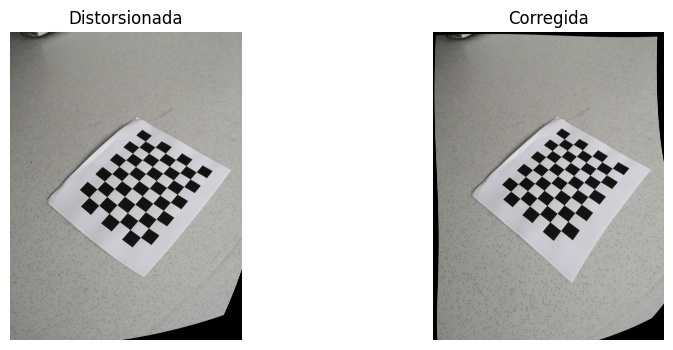

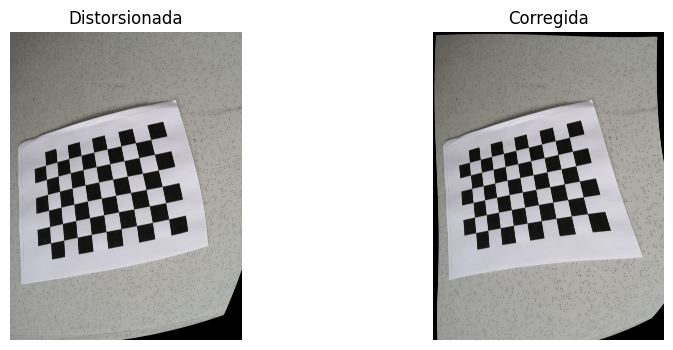

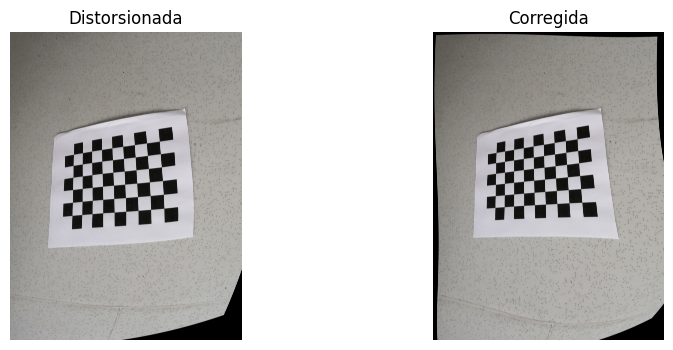

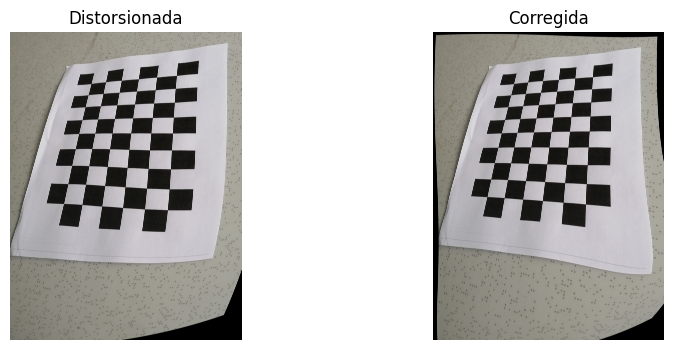

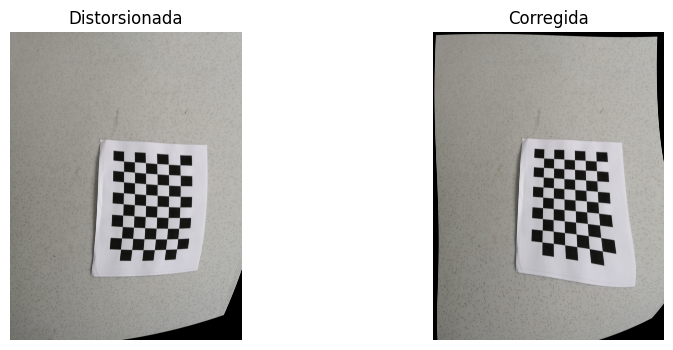

In [46]:
imagenes_distorsionadas = glob.glob(os.path.join(ruta_distorsionadas, '*.jpg'))

mostradas = 0
for fname in imagenes_distorsionadas:
    base_name = os.path.basename(fname)
    ruta_corregida = os.path.join(ruta_corregidas, base_name)

    if os.path.exists(ruta_corregida):
        dist = cv2.imread(fname)
        corr = cv2.imread(ruta_corregida)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))
        plt.title("Distorsionada")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(corr, cv2.COLOR_BGR2RGB))
        plt.title("Corregida")
        plt.axis("off")

        plt.show()

        mostradas += 1
        if mostradas == 5:
            break
